Survival analysis
=================
Survival analysis for C60 paper

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from lifelines import *
from lifelines.statistics import *

In [3]:
from pathlib import Path
import sys
import inspect

local = Path("..").resolve() if (Path("..") / "data").exists() else Path(".")

In [4]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.float_format', lambda x: '%.3f' % x)


<ipython-input-4-b73db489d492>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # or 199


## C60 data loading and pre-processing ##

In [5]:
from pathlib import Path
data = local / "data"
input = data / "input"
output = data / "output"
input.absolute()

PosixPath('/data/sources/C60/data/input')

In [6]:
mice = pd.read_csv(input / "С60_paper_survival.csv", na_values = "NA")
mice["died_from_aging"] = mice["Censored"] == 0
mice["lifespan"] = mice["Lifespan (BD-death)"] #just to make it shorter
mice.head(10)


,Mouse,Cage,Drg,Sex,GROUP,BD,age t0,death original,death,Lifespan (BD-death),"Age stratification (LF=0-0.74, LF>0.75)","Age stratification (LF=0-0.33, LF=0.33-0.67, LF=0.67-1)",Censored,Problem,Var14,BW-1,BW0,BW1,BW2,BW3,BW4,BW5,BW6,BW7,BW8,BW9,BW10,BW11,BW12,BW13,BW14,BW15,Var32,OFT,OFT 0,OFT3,OFT6,OFT9,OFT12,paw strength,2 paw_0,2 paw_3,2 paw_6,2 paw_9,2 paw_12,4 paw_0,4 paw_3,4 paw_6,4 paw_9,4 paw_12,rotarod,T0,T3,T6,T9,T12,GTT,AUC0,AUC3,AUC6,AUC9,AUC12,Fasting glucose,T1,T2,T3.1,T4,T5,Limb strength / BW,"2L/S 0 (!~\FT1,,,=v39/v15)","2L/S 3 (!~\FT1,,,=v41/v18)","2L/S 6 (!~\FT1,,,=v43/v21)","2L/S 9 (!~\FT1,,,=v45/v24)","2L/S 12 (!~\FT1,,,=v47/v27)",Var68,"4L/S 0 (!~\FT1,,,=v40/v15)","4L/S 3 (!~\FT1,,,=v42/v18)","4L/S 6 (!~\FT1,,,=v44/v21)","4L/S 9 (!~\FT1,,,=v46/v24)","4L/S 12 (!~\FT1,,,=v48/v27)",NECROPSIA,Examination done,Tumor,Any body damage,"BW upon death, g","Kidney mass, mg","Adrenals, mg","Spleen, mg","Liver, mg","Lungs, mg","Testicles, mg","Heart, mg",Var192,"Kidney to BW, %","Adrenals to BW, %","Spleen to BW, %","Liver to BW, %","Lungs to BW, %","Testicles to BW, %","Heart to BW, %",Var199,Var200,BW1.1,BW2.1,BW3.1,BW4.1,BW5.1,BW6.1,BW7.1,BW8.1,BW9.1,BW10.1,BW11.1,BW12.1,died_from_aging,lifespan
0,12,3',Drinking water,F,F-H2O,2013/10/15,27/10/14,28.09.2015,2015/09/28,703,1,2,0,0,NaN,21.900,21.500,23.000,24.800,25.000,25.700,22.100,25.800,25.000,24,24.9,25.600,22.2,26.440323,NaN,NaN,NaN,NaN,NaN,0.000,5.000,0.000,0.000,NaN,NaN,106.000,65.000,63.000,62.000,NaN,170.000,122.000,168.000,142.000,NaN,NaN,180.000,180.000,67.000,89.000,NaN,NaN,257.900,210.800,228.300,369.000,NaN,NaN,5.500,5.300,4.000,5.900,NaN,NaN,4.930,2.600,2.442,2.490,NaN,NaN,7.907,4.880,6.512,5.703,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000,24.800,25.000,25.700,22.100,25.800,25.000,24.000,24.900,25.600,22.200,NaN,True,703
1,13,3',Drinking water,F,F-H2O,2013/10/15,27/10/14,13.11.2014,2014/11/13,388,1,1,0,1,NaN,24.300,27.512,27.319,27.798,27.846,27.709,27.694,27.494,27.722,27.232973,27.285882,26.930,26.951773,26.440323,NaN,NaN,NaN,NaN,NaN,28.000,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN,NaN,149.000,NaN,NaN,NaN,NaN,NaN,180.000,NaN,NaN,NaN,NaN,NaN,316.500,NaN,NaN,NaN,NaN,NaN,3.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,388
2,14,3',Drinking water,F,F-H2O,2013/10/15,27/10/14,17.11.2014,2014/11/17,392,1,1,0,1,NaN,22.900,27.512,27.319,27.798,27.846,27.709,27.694,27.494,27.722,27.232973,27.285882,26.930,26.951773,26.440323,NaN,NaN,NaN,NaN,NaN,11.000,NaN,NaN,NaN,NaN,NaN,108.000,NaN,NaN,NaN,NaN,110.000,NaN,NaN,NaN,NaN,NaN,180.000,NaN,NaN,NaN,NaN,NaN,304.500,NaN,NaN,NaN,NaN,NaN,4.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,392
3,19,6',Drinking water,F,F-H2O,2013/11/15,12/04/14,30.03.2015,2015/03/30,495,1,1,0,0,NaN,26.500,24.100,25.100,22.800,22.600,22.300,27.694,27.494,27.722,27.232973,27.285882,26.930,1/25/1900,26.440323,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,117.000,51.000,NaN,NaN,NaN,130.000,187.000,NaN,NaN,NaN,NaN,180.000,135.000,NaN,NaN,NaN,NaN,251.300,90.750,NaN,NaN,NaN,NaN,4.500,4.200,NaN,NaN,NaN,NaN,4.855,2.257,NaN,NaN,NaN,NaN,5.394,8.274,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.100,22.800,22.600,22.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,495
4,20,6',Drinking water,F,F-H2O,2013/11/15,12/04/14,24.01.2016 ×Ï,2016/01/24,789,2,3,1,0,NaN,25.800,25.700,25.800,24.000,25.500,26.600,25.300,26.300,25.500,25.1,26.1,26.300,24.9,25.5,23.900,23.900,NaN,NaN,NaN,6.000,27.000,26.000,21.000,28.000,NaN,125.000,92.000,NaN,67.000,98.000,196.000,153.000,189.000,160.000,157.000,NaN,180.000,180.000,180.000,180.000,180.000,NaN,372.000,283.500,

In [7]:
mice_males = mice[mice["Sex"]=="M"]
mice_females = mice[mice["Sex"]=="F"]
mice_females.head(10)

,Mouse,Cage,Drg,Sex,GROUP,BD,age t0,death original,death,Lifespan (BD-death),"Age stratification (LF=0-0.74, LF>0.75)","Age stratification (LF=0-0.33, LF=0.33-0.67, LF=0.67-1)",Censored,Problem,Var14,BW-1,BW0,BW1,BW2,BW3,BW4,BW5,BW6,BW7,BW8,BW9,BW10,BW11,BW12,BW13,BW14,BW15,Var32,OFT,OFT 0,OFT3,OFT6,OFT9,OFT12,paw strength,2 paw_0,2 paw_3,2 paw_6,2 paw_9,2 paw_12,4 paw_0,4 paw_3,4 paw_6,4 paw_9,4 paw_12,rotarod,T0,T3,T6,T9,T12,GTT,AUC0,AUC3,AUC6,AUC9,AUC12,Fasting glucose,T1,T2,T3.1,T4,T5,Limb strength / BW,"2L/S 0 (!~\FT1,,,=v39/v15)","2L/S 3 (!~\FT1,,,=v41/v18)","2L/S 6 (!~\FT1,,,=v43/v21)","2L/S 9 (!~\FT1,,,=v45/v24)","2L/S 12 (!~\FT1,,,=v47/v27)",Var68,"4L/S 0 (!~\FT1,,,=v40/v15)","4L/S 3 (!~\FT1,,,=v42/v18)","4L/S 6 (!~\FT1,,,=v44/v21)","4L/S 9 (!~\FT1,,,=v46/v24)","4L/S 12 (!~\FT1,,,=v48/v27)",NECROPSIA,Examination done,Tumor,Any body damage,"BW upon death, g","Kidney mass, mg","Adrenals, mg","Spleen, mg","Liver, mg","Lungs, mg","Testicles, mg","Heart, mg",Var192,"Kidney to BW, %","Adrenals to BW, %","Spleen to BW, %","Liver to BW, %","Lungs to BW, %","Testicles to BW, %","Heart to BW, %",Var199,Var200,BW1.1,BW2.1,BW3.1,BW4.1,BW5.1,BW6.1,BW7.1,BW8.1,BW9.1,BW10.1,BW11.1,BW12.1,died_from_aging,lifespan
0,12,3',Drinking water,F,F-H2O,2013/10/15,27/10/14,28.09.2015,2015/09/28,703,1,2,0,0,NaN,21.900,21.500,23.000,24.800,25.000,25.700,22.100,25.800,25.000,24,24.9,25.600,22.2,26.440323,NaN,NaN,NaN,NaN,NaN,0.000,5.000,0.000,0.000,NaN,NaN,106.000,65.000,63.000,62.000,NaN,170.000,122.000,168.000,142.000,NaN,NaN,180.000,180.000,67.000,89.000,NaN,NaN,257.900,210.800,228.300,369.000,NaN,NaN,5.500,5.300,4.000,5.900,NaN,NaN,4.930,2.600,2.442,2.490,NaN,NaN,7.907,4.880,6.512,5.703,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000,24.800,25.000,25.700,22.100,25.800,25.000,24.000,24.900,25.600,22.200,NaN,True,703
1,13,3',Drinking water,F,F-H2O,2013/10/15,27/10/14,13.11.2014,2014/11/13,388,1,1,0,1,NaN,24.300,27.512,27.319,27.798,27.846,27.709,27.694,27.494,27.722,27.232973,27.285882,26.930,26.951773,26.440323,NaN,NaN,NaN,NaN,NaN,28.000,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN,NaN,149.000,NaN,NaN,NaN,NaN,NaN,180.000,NaN,NaN,NaN,NaN,NaN,316.500,NaN,NaN,NaN,NaN,NaN,3.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,388
2,14,3',Drinking water,F,F-H2O,2013/10/15,27/10/14,17.11.2014,2014/11/17,392,1,1,0,1,NaN,22.900,27.512,27.319,27.798,27.846,27.709,27.694,27.494,27.722,27.232973,27.285882,26.930,26.951773,26.440323,NaN,NaN,NaN,NaN,NaN,11.000,NaN,NaN,NaN,NaN,NaN,108.000,NaN,NaN,NaN,NaN,110.000,NaN,NaN,NaN,NaN,NaN,180.000,NaN,NaN,NaN,NaN,NaN,304.500,NaN,NaN,NaN,NaN,NaN,4.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,392
3,19,6',Drinking water,F,F-H2O,2013/11/15,12/04/14,30.03.2015,2015/03/30,495,1,1,0,0,NaN,26.500,24.100,25.100,22.800,22.600,22.300,27.694,27.494,27.722,27.232973,27.285882,26.930,1/25/1900,26.440323,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,117.000,51.000,NaN,NaN,NaN,130.000,187.000,NaN,NaN,NaN,NaN,180.000,135.000,NaN,NaN,NaN,NaN,251.300,90.750,NaN,NaN,NaN,NaN,4.500,4.200,NaN,NaN,NaN,NaN,4.855,2.257,NaN,NaN,NaN,NaN,5.394,8.274,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.100,22.800,22.600,22.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,495
4,20,6',Drinking water,F,F-H2O,2013/11/15,12/04/14,24.01.2016 ×Ï,2016/01/24,789,2,3,1,0,NaN,25.800,25.700,25.800,24.000,25.500,26.600,25.300,26.300,25.500,25.1,26.1,26.300,24.9,25.5,23.900,23.900,NaN,NaN,NaN,6.000,27.000,26.000,21.000,28.000,NaN,125.000,92.000,NaN,67.000,98.000,196.000,153.000,189.000,160.000,157.000,NaN,180.000,180.000,180.000,180.000,180.000,NaN,372.000,283.500,

In [8]:
mice_water = mice[mice["Drg"] == "Drinking water"]
mice_C60 =  mice[mice["Drg"]=="C60"]
mice_oil =  mice[mice["Drg"] == "Olive oil"]
mice_C60.head(10)

,Mouse,Cage,Drg,Sex,GROUP,BD,age t0,death original,death,Lifespan (BD-death),"Age stratification (LF=0-0.74, LF>0.75)","Age stratification (LF=0-0.33, LF=0.33-0.67, LF=0.67-1)",Censored,Problem,Var14,BW-1,BW0,BW1,BW2,BW3,BW4,BW5,BW6,BW7,BW8,BW9,BW10,BW11,BW12,BW13,BW14,BW15,Var32,OFT,OFT 0,OFT3,OFT6,OFT9,OFT12,paw strength,2 paw_0,2 paw_3,2 paw_6,2 paw_9,2 paw_12,4 paw_0,4 paw_3,4 paw_6,4 paw_9,4 paw_12,rotarod,T0,T3,T6,T9,T12,GTT,AUC0,AUC3,AUC6,AUC9,AUC12,Fasting glucose,T1,T2,T3.1,T4,T5,Limb strength / BW,"2L/S 0 (!~\FT1,,,=v39/v15)","2L/S 3 (!~\FT1,,,=v41/v18)","2L/S 6 (!~\FT1,,,=v43/v21)","2L/S 9 (!~\FT1,,,=v45/v24)","2L/S 12 (!~\FT1,,,=v47/v27)",Var68,"4L/S 0 (!~\FT1,,,=v40/v15)","4L/S 3 (!~\FT1,,,=v42/v18)","4L/S 6 (!~\FT1,,,=v44/v21)","4L/S 9 (!~\FT1,,,=v46/v24)","4L/S 12 (!~\FT1,,,=v48/v27)",NECROPSIA,Examination done,Tumor,Any body damage,"BW upon death, g","Kidney mass, mg","Adrenals, mg","Spleen, mg","Liver, mg","Lungs, mg","Testicles, mg","Heart, mg",Var192,"Kidney to BW, %","Adrenals to BW, %","Spleen to BW, %","Liver to BW, %","Lungs to BW, %","Testicles to BW, %","Heart to BW, %",Var199,Var200,BW1.1,BW2.1,BW3.1,BW4.1,BW5.1,BW6.1,BW7.1,BW8.1,BW9.1,BW10.1,BW11.1,BW12.1,died_from_aging,lifespan
85,1,1',C60,F,F-C60,2013/10/15,27/10/14,24.01.2016 ×Ï,2016/01/24,819,1,3,1,0,NaN,25.300,24.100,23.800,22.300,23.600,24.600,23.800,23.400,23.600,23.9,23.8,24.700,24.3,24.2,NaN,NaN,NaN,NaN,NaN,0.000,8.000,2.000,7.000,0.000,NaN,98.000,86.000,85.000,65.000,80.000,131.000,143.000,237.000,159.000,161.000,NaN,180.000,180.000,180.000,180.000,180.000,NaN,476.300,393.000,348.000,378.000,169.500,NaN,3.600,3.800,6.400,5.600,3.300,NaN,4.066,3.644,3.632,2.731,3.306,NaN,5.436,6.059,10.128,6.681,6.653,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.100,23.800,22.300,23.600,24.600,23.800,23.400,23.600,23.900,23.800,24.700,24.300,NaN,False,819
86,2,1',C60,F,F-C60,2013/10/15,27/10/14,26.08.2015,2015/08/26,671,1,2,0,0,NaN,21.000,21.700,22.300,21.900,21.500,21.600,22.800,23.400,22.300,21.3,23.8,24.200,26.951773,26.440323,NaN,NaN,NaN,NaN,NaN,4.000,40.000,20.000,1.000,NaN,NaN,107.000,78.000,62.000,66.000,NaN,175.000,163.000,158.000,130.000,NaN,NaN,180.000,180.000,180.000,180.000,NaN,NaN,382.500,318.000,219.800,357.000,NaN,NaN,5.000,3.600,4.400,6.100,NaN,NaN,4.931,3.628,2.650,2.773,NaN,NaN,8.065,7.581,6.752,5.462,NaN,NaN,0,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.700,22.300,21.900,21.500,21.600,22.800,23.400,22.300,21.300,23.800,24.200,NaN,NaN,True,671
87,3,1',C60,F,F-C60,2013/10/15,27/10/14,24.01.2016 ×Ï,2016/01/24,819,1,3,1,0,NaN,26.800,28.300,37.600,30.100,27.600,28.200,32.400,28.300,28.100,28,26.6,28.400,28.6,27.3,NaN,NaN,NaN,NaN,NaN,2.000,8.000,0.000,1.000,18.000,NaN,109.000,118.000,80.000,64.000,98.000,164.000,150.000,188.000,131.000,169.000,NaN,180.000,180.000,180.000,180.000,180.000,NaN,375.800,325.500,166.500,348.800,78.750,NaN,5.400,3.700,5.200,5.100,3.100,NaN,3.852,4.275,2.827,2.406,3.590,NaN,5.795,5.435,6.643,4.925,6.190,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.300,37.600,30.100,27.600,28.200,32.400,28.300,28.100,28.000,26.600,28.400,28.600,NaN,False,819
88,4,1',C60,F,F-C60,2013/10/15,27/10/14,24.01.2016 ×Ï,2016/01/24,819,1,3,1,0,NaN,24.700,23.700,23.900,24.100,23.400,24.100,23.800,23.800,25.000,26.3,25.9,25.900,25.2,24.9,NaN,NaN,NaN,NaN,NaN,0.000,0.000,1.000,3.000,4.000,NaN,121.000,93.000,74.000,57.000,78.000,184.000,163.000,145.000,121.000,199.000,NaN,180.000,180.000,180.000,180.000,180.000,NaN,417.000,279.000,373.500,313.500,152.300,NaN,4.800,3.700,4.600,4.800,3.600,NaN,5.105,3.974,3.109,2.201,3.133,NaN,7.764,6.966,6.092,4.672,7.992,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.700,23.900,24.100,23.400,24.100,23.800,23.800,25.000,26.300,25.900,25.900,25.200,NaN,False,819
89,29,8',C60,F,F-C60,2013/11/15,12/04/14,24.09.2015,2015/09/24,669,1,2,0,0,NaN,22.400,22.600,23.100,23.700,

In [9]:
mice_water_males = mice[mice["GROUP"]=="M-H2O"]
mice_oil_males = mice[mice["GROUP"]=="M-Oil"]
mice_C60_males = mice[mice["GROUP"]=="M-C60"]

In [10]:
mice_water_females = mice[mice["GROUP"]=="F-H2O"]
mice_oil_females = mice[mice["GROUP"]=="F-Oil"]
mice_C60_females = mice[mice["GROUP"]=="F-C60"]

Plotting
========
Preparing the plots for the data

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from lifelines import *

In [12]:
mice["lifespan"].shape

(246,)

### Styles ###

In [55]:
water_color = "#0060e1"
oil_color = "#000000"
C60_color = "#ff0000"
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc("lines", linewidth=3)
plt.rc('font', **font)

Survival curves
---------------

Text(0.5, 0, 'Age (days)')

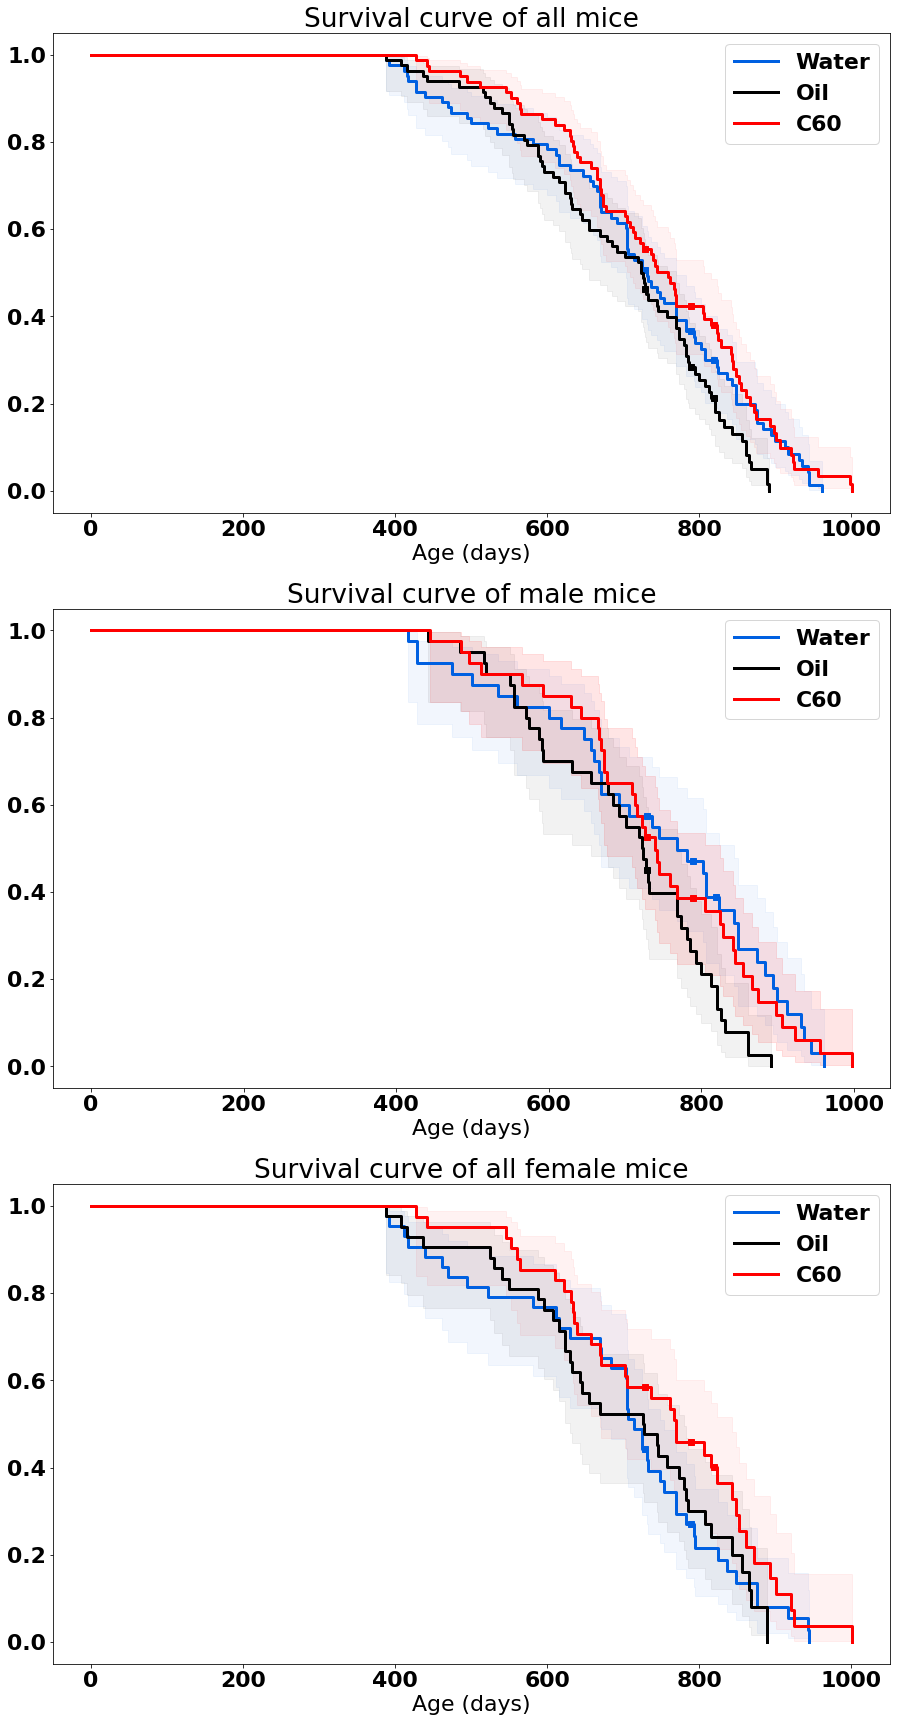

In [83]:
fig, axes = plt.subplots(3, 1, figsize=(15, 30))
survival_alpha = 0.05

#ALL
kmf_all_water = KaplanMeierFitter()        
kmf_all_water.fit(mice_water["lifespan"], event_observed = mice_water["died_from_aging"], label="Water")   
kmf_all_water_subplot = kmf_all_water.plot_survival_function(ax=axes[0], ci_alpha=survival_alpha, color = water_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})   
#kmf.plot_cumulative_density(ax=axes[0][1], ci_alpha = 0.1)

kmf_all_oil = KaplanMeierFitter()        
kmf_all_oil.fit(mice_oil["lifespan"], event_observed = mice_oil["died_from_aging"], label="Oil")   
kmf_all_oil.plot_survival_function(ax=axes[0],  ci_alpha=survival_alpha, color = oil_color, show_censors=True , censor_styles={'ms': 6, 'marker': 's'})
#kmf.plot_cumulative_density(ax=axes[0][1], ci_alpha = 0.1)

kmf_all_c60 = KaplanMeierFitter()   
kmf_all_c60.fit(mice_C60["lifespan"], event_observed = mice_C60["died_from_aging"], label="C60")   
kmf_all_c60.plot_survival_function(ax=axes[0], title= "Survival curve of all mice", ci_alpha=survival_alpha, color = C60_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
#kmf.plot_cumulative_density(ax=axes[0][1], ci_alpha = 0.1, title="Cumulative density for all mice")



#Males
kmf_males_water = KaplanMeierFitter() 
kmf_males_water.fit(mice_water_males["lifespan"], event_observed = mice_water_males["died_from_aging"], label="Water")   
kmf_males_water.plot_survival_function(ax=axes[1], ci_alpha=survival_alpha, color = water_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})    
#kmf.plot_cumulative_density(ax=axes[1][1], ci_alpha = 0.1)

kmf_males_oil = KaplanMeierFitter() 
kmf_males_oil.fit(mice_oil_males["lifespan"], event_observed = mice_oil_males["died_from_aging"], label="Oil")   
kmf_males_oil.plot_survival_function(ax=axes[1], ci_alpha=survival_alpha, color = oil_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
#kmf.plot_cumulative_density(ax=axes[1][1], ci_alpha = 0.1)

kmf_males_C60 = KaplanMeierFitter() 
kmf_males_C60.fit(mice_C60_males["lifespan"], event_observed = mice_C60_males["died_from_aging"], label="C60")   
kmf_males_C60.plot_survival_function(ax=axes[1], title= "Survival curve of male mice", ci_alpha=0.1, color = C60_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
#kmf.plot_cumulative_density(ax=axes[1][1], ci_alpha = 0.1, title="Cumulative density for male mice")


#Females
kmf_females_water = KaplanMeierFitter()        
kmf_females_water.fit(mice_water_females["lifespan"], event_observed = mice_water_females["died_from_aging"], label="Water")   
kmf_females_water.plot_survival_function(ax=axes[2], ci_alpha=survival_alpha, color = water_color, show_censors=True,  censor_styles={'ms': 6, 'marker': 's'})    
#kmf.plot_cumulative_density(ax=axes[2][1], ci_alpha = 0.1)

kmf_females_oil = KaplanMeierFitter()        
kmf_females_oil.fit(mice_oil_females["lifespan"], event_observed = mice_oil_females["died_from_aging"], label="Oil")   
kmf_females_oil.plot_survival_function(ax=axes[2], ci_alpha=survival_alpha, color = oil_color)
#kmf.plot_cumulative_density(ax=axes[2][1], ci_alpha = 0.1)


kmf_females_c60 = KaplanMeierFitter()   
kmf_females_c60.fit(mice_C60_females["lifespan"], event_observed = mice_C60_females["died_from_aging"], label="C60")   
kmf_females_c60.plot_survival_function(ax=axes[2], title= "Survival curve of all female mice", ci_alpha=survival_alpha,  color = C60_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
#kmf.plot_cumulative_density(ax=axes[2][1], ci_alpha = 0.1, title="Cumulative density for female mice")
axes[0].set_xlabel("Age (days)")
axes[1].set_xlabel("Age (days)")
axes[2].set_xlabel("Age (days)")



Hazzard models
===============

The survival functions is a great way to summarize and visualize the survival dataset, however it is not the only way. 

[img](https://lifelines.readthedocs.io/en/latest/_images/map.png)

If we are curious about the hazard function h(t) of a population, we unfortunately cannot transform the Kaplan Meier estimate – statistics doesn’t work quite that well. 
Fortunately, there is a proper non-parametric estimator of the cumulative hazard function - Nelson Aalen estimator ( https://en.wikipedia.org/wiki/Nelson%E2%80%93Aalen_estimator )

Text(0.5, 0, 'Age (days)')

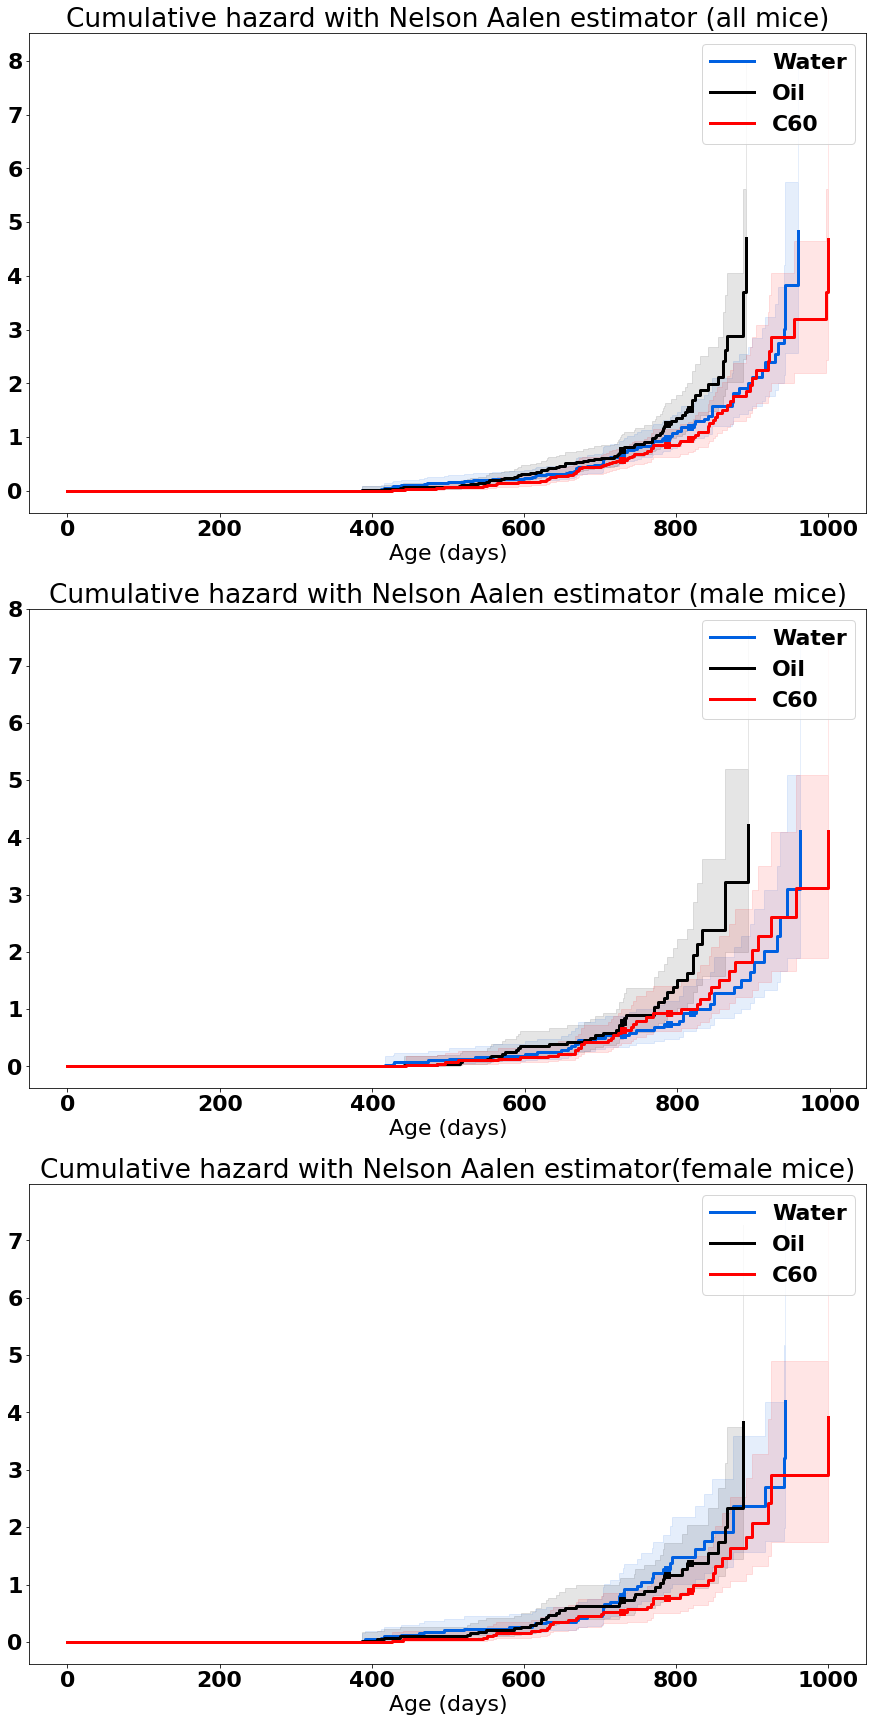

In [84]:
from lifelines import NelsonAalenFitter
fig, axes = plt.subplots(3, 1, figsize=(15, 30))
hazzard_alpha = 0.1 #transparency of confidence intervals

#ALL
naf_all_water = NelsonAalenFitter()        
naf_all_water.fit(mice_water["lifespan"], event_observed = mice_water["died_from_aging"], label="Water")   
naf_all_water.plot(ax=axes[0], ci_alpha=hazzard_alpha, color = water_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})    
#naf.plot_cumulative_density(ax=axes[0][1], ci_alpha = 0.1)

naf_all_oil = NelsonAalenFitter()        
naf_all_oil.fit(mice_oil["lifespan"], event_observed = mice_oil["died_from_aging"], label="Oil")   
naf_all_oil.plot(ax=axes[0],  ci_alpha=hazzard_alpha, color = oil_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
#naf.plot_cumulative_density(ax=axes[0][1], ci_alpha = 0.1)

naf_all_c60 = NelsonAalenFitter()   
naf_all_c60.fit(mice_C60["lifespan"], event_observed = mice_C60["died_from_aging"], label="C60")   
naf_all_c60.plot(ax=axes[0], title= "Cumulative hazard with Nelson Aalen estimator (all mice)", ci_alpha=hazzard_alpha, color = C60_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
#naf.plot_cumulative_density(ax=axes[0][1], ci_alpha = 0.1, title="Cumulative density for all mice")


#Males
naf_males_water = NelsonAalenFitter() 
naf_males_water.fit(mice_water_males["lifespan"], event_observed = mice_water_males["died_from_aging"], label="Water")   
naf_males_water.plot(ax=axes[1], ci_alpha=hazzard_alpha, color = water_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})    
#naf.plot_cumulative_density(ax=axes[1][1], ci_alpha = 0.1)

naf_males_oil = NelsonAalenFitter() 
naf_males_oil.fit(mice_oil_males["lifespan"], event_observed = mice_oil_males["died_from_aging"], label="Oil")   
naf_males_oil.plot(ax=axes[1], ci_alpha=hazzard_alpha, color = oil_color, show_censors=True,  censor_styles={'ms': 6, 'marker': 's'})
#naf.plot_cumulative_density(ax=axes[1][1], ci_alpha = 0.1)

naf_males_C60 = NelsonAalenFitter() 
naf_males_C60.fit(mice_C60_males["lifespan"], event_observed = mice_C60_males["died_from_aging"], label="C60")   
naf_males_C60.plot(ax=axes[1], title= "Cumulative hazard with Nelson Aalen estimator (male mice)", ci_alpha=hazzard_alpha,  color = C60_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
#naf.plot_cumulative_density(ax=axes[1][1], ci_alpha = 0.1, title="Cumulative density for male mice")


#Females
naf_females_water = NelsonAalenFitter()        
naf_females_water.fit(mice_water_females["lifespan"], event_observed = mice_water_females["died_from_aging"], label="Water")   
naf_females_water.plot(ax=axes[2], ci_alpha=hazzard_alpha, color = water_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})    
#naf.plot_cumulative_density(ax=axes[2][1], ci_alpha = 0.1)

naf_females_oil = NelsonAalenFitter()        
naf_females_oil.fit(mice_oil_females["lifespan"], event_observed = mice_oil_females["died_from_aging"], label="Oil")   
naf_females_oil.plot(ax=axes[2], ci_alpha=hazzard_alpha, color = oil_color, show_censors=True,  censor_styles={'ms': 6, 'marker': 's'})
#naf.plot_cumulative_density(ax=axes[2][1], ci_alpha = 0.1)


naf_females_c60 = NelsonAalenFitter()   
naf_females_c60.fit(mice_C60_females["lifespan"], event_observed = mice_C60_females["died_from_aging"], label="C60")   
naf_females_c60.plot(ax=axes[2], title= "Cumulative hazard with Nelson Aalen estimator(female mice)", ci_alpha=hazzard_alpha,  color = C60_color, show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
#naf.plot_cumulative_density(ax=axes[2][1], ci_alpha = 0.1, title="Cumulative density for female mice")

axes[0].set_xlabel("Age (days)")
axes[1].set_xlabel("Age (days)")
axes[2].set_xlabel("Age (days)")



Statistical analysis
--------------------
Reproducing paper's statistical analysis

Pairwise logrank test
=====================

In [17]:
pairwise_logrank_test(mice["lifespan"], mice["Drg"], mice["died_from_aging"])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                               test_statistic      p  -log2(p)
C60            Drinking water            0.73   0.39      1.34
               Olive oil                 7.98 <0.005      7.72
Drinking water Olive oil                 3.89   0.05      4.36

In [19]:
pairwise_logrank_test(mice_males["lifespan"], mice_males["Drg"], mice_males["died_from_aging"])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                               test_statistic    p  -log2(p)
C60            Drinking water            0.05 0.82      0.29
               Olive oil                 4.21 0.04      4.64
Drinking water Olive oil                 6.70 0.01      6.69

In [21]:
pairwise_logrank_test(mice_females["lifespan"], mice_females["Drg"], mice_females["died_from_aging"])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                               test_statistic    p  -log2(p)
C60            Drinking water            2.25 0.13      2.91
               Olive oil                 3.53 0.06      4.05
Drinking water Olive oil                 0.01 0.93      0.10

Multivariate logrank test
=========================

In [23]:
multivariate_logrank_test(mice["lifespan"], mice["Drg"], mice["died_from_aging"])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           7.93 0.02      5.72

In [24]:
multivariate_logrank_test(mice_males["lifespan"], mice_males["Drg"], mice_males["died_from_aging"])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           7.13 0.03      5.14

In [25]:
multivariate_logrank_test(mice_females["lifespan"], mice_females["Drg"], mice_females["died_from_aging"])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           3.58 0.17      2.58

At fixed point in time
======================

In [26]:
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
survival_difference_at_fixed_point_in_time_test(724, kmf_males_C60, kmf_males_oil)

<lifelines.StatisticalResult: survival_difference_at_fixed_point_in_time_test>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 724
           fitterA = <lifelines.KaplanMeierFitter:"C60", fitted with 40 total observations, 3 right-censored observations>
           fitterB = <lifelines.KaplanMeierFitter:"Oil", fitted with 40 total observations, 1 right-censored observations>
         test_name = survival_difference_at_fixed_point_in_time_test

---
 test_statistic    p  -log2(p)
           0.44 0.51      0.98

In [27]:
survival_difference_at_fixed_point_in_time_test(727, kmf_males_C60, kmf_males_oil)

<lifelines.StatisticalResult: survival_difference_at_fixed_point_in_time_test>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 727
           fitterA = <lifelines.KaplanMeierFitter:"C60", fitted with 40 total observations, 3 right-censored observations>
           fitterB = <lifelines.KaplanMeierFitter:"Oil", fitted with 40 total observations, 1 right-censored observations>
         test_name = survival_difference_at_fixed_point_in_time_test

---
 test_statistic    p  -log2(p)
           0.19 0.66      0.60